# CNN-Based Melanoma Detection

## Introduction

This notebook focuses on building and evaluating convolutional neural networks (CNNs) for melanoma detection. Melanoma is one of the deadliest types of skin cancer, and early detection can save lives. The goal is to identify melanomas from dermoscopic images with high accuracy and recall.

### Notebook Workflow:
1. Preprocess the dataset (data augmentation and normalization).
2. Train multiple CNN architectures with varying configurations.
3. Evaluate the models using metrics like accuracy, precision, recall, F1-score, and ROC-AUC.
4. Recommend the best-performing model for real-world deployment.

## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The workflow includes:
- **Data Loading and Preprocessing**
- **Model Architecture and Training**
- **Evaluation and Visualizations**
- **Final Recommendations**


## Objective
- To build a Convolutional Neural Network (CNN) that can accurately detect melanoma using skin cancer image data.
- Melanoma is a dangerous form of skin cancer that can be life-threatening if not detected early.

## Steps Involved:
- Importing libraries.
- Loading and visualizing the dataset.
- Preprocessing data for training.
- Building a CNN model.
- Training, evaluating, and visualizing results.

### Importing Libraries
- Importing essential libraries for data preprocessing, model building, and evaluation.

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress TensorFlow info and warning logs to keep output clean
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [72]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [74]:
pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\raghu\anaconda3\envs\tf_gpu\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [76]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [78]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [80]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [82]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Perform a small computation
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
    c = tf.matmul(a, b)
    print("Result of computation on GPU:\n", c)

TensorFlow version: 2.10.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Result of computation on GPU:
 tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)


In [84]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


## Data Preparation
1. Loaded and split data into training, validation, and test sets.
2. Rescaled images to a size of **180x180**.
3. Augmented the dataset using techniques such as rotation, flipping, and zooming to improve generalization.


In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directories
train_dir = 'Train'
test_dir = 'Test'

# Create an ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # 20% validation split
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
)

Found 3955 images belonging to 9 classes.
Found 984 images belonging to 9 classes.
Found 118 images belonging to 10 classes.


In [89]:
for x, y in validation_generator:
    print(x.shape, y.shape)
    break  # Ensure it stops after one batch.

(32, 180, 180, 3) (32, 9)


In [91]:
print("Validation Class Indices:", validation_generator.class_indices)
print("Number of Classes:", len(validation_generator.class_indices))

Validation Class Indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Number of Classes: 9


In [93]:
for x, y in train_generator:
    print(x.shape, y.shape)
    break

for x, y in validation_generator:
    print(x.shape, y.shape)
    break


(32, 180, 180, 3) (32, 9)
(32, 180, 180, 3) (32, 9)


### Dataset:
- Training set: 3955 images across 9 classes.
- Validation set: 984 images (20% of training data).
- Test set: 118 images across 9 classes.

In [95]:
print(train_generator.class_indices)


{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


## Data Visualization
Visualize one sample per class to verify preprocessing and augmentations.

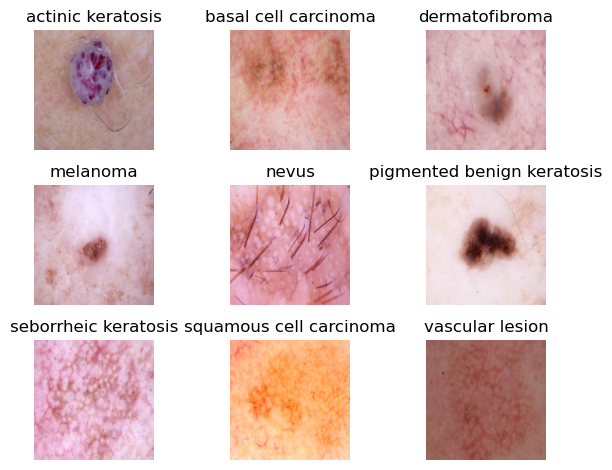

In [97]:
# Visualize one instance per class
classes = list(train_generator.class_indices.keys())
for i, class_name in enumerate(classes):
    # Use next() function to get a batch of images and labels
    img, label = next(train_generator)
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0])  # Display the first image in the batch
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


## Model 1: Baseline CNN

This model uses a simple CNN architecture with two convolutional blocks and dropout layers.

## CNN Architecture
This model builds with the following refinements:
1. Additional Conv2D layer for improved feature extraction.
2. Increased filters in convolutional layers.
3. Dropout regularization to prevent overfitting.
4. Batch normalization for stable training.

In [11]:
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])


In [13]:
# Assuming `train_generator.classes` gives the class labels
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes,
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)


{0: 1.323627844712182, 1: 0.8122817827069213, 2: 1.390646976090014, 3: 0.7435608197029517, 4: 0.8354457118715674, 5: 0.7204007285974499, 6: 1.4551140544518029, 7: 1.1414141414141414, 8: 1.2484217171717171}


## Compile the Baseline CNN Model-1
Using Adam optimizer with varying learning rates and categorical crossentropy as the loss function.

In [15]:
from tensorflow.keras.metrics import Precision, Recall

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Compile the model before training
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy', Precision(), Recall()]  # Using keras.metrics.Precision and Recall
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights_dict,  # If using class weights
)

Epoch 1/20
124/124 [==============================] - 45s 346ms/step - loss: 2.0037 - accuracy: 0.2260 - precision: 0.5268 - recall: 0.0422 - val_loss: 1.7245 - val_accuracy: 0.3476 - val_precision: 0.6531 - val_recall: 0.0976
Epoch 2/20
124/124 [==============================] - 51s 410ms/step - loss: 1.6789 - accuracy: 0.3350 - precision: 0.6331 - recall: 0.1130 - val_loss: 1.7391 - val_accuracy: 0.3445 - val_precision: 0.5419 - val_recall: 0.1250
Epoch 3/20
124/124 [==============================] - 45s 361ms/step - loss: 1.5750 - accuracy: 0.3767 - precision: 0.6794 - recall: 0.1489 - val_loss: 1.6016 - val_accuracy: 0.4167 - val_precision: 0.5690 - val_recall: 0.1382
Epoch 4/20
124/124 [==============================] - 49s 396ms/step - loss: 1.4965 - accuracy: 0.4250 - precision: 0.6673 - recall: 0.1659 - val_loss: 1.5433 - val_accuracy: 0.4614 - val_precision: 0.6296 - val_recall: 0.1728
Epoch 5/20
124/124 [==============================] - 49s 394ms/step - loss: 1.4501 - accura

4/4 [==============================] - 6s 2s/step
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.06      0.11        16
      basal cell carcinoma       0.00      0.00      0.00        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.25      0.12      0.17        16
            melanoma_tuner       0.00      0.00      0.00         0
                     nevus       0.10      0.19      0.13        16
pigmented benign keratosis       0.00      0.00      0.00        16
      seborrheic keratosis       0.09      0.33      0.14         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.06       118
                 macro avg       0.09      0.07      0.06       118
              weighted avg       0.12      0.06      0.06       

C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAG

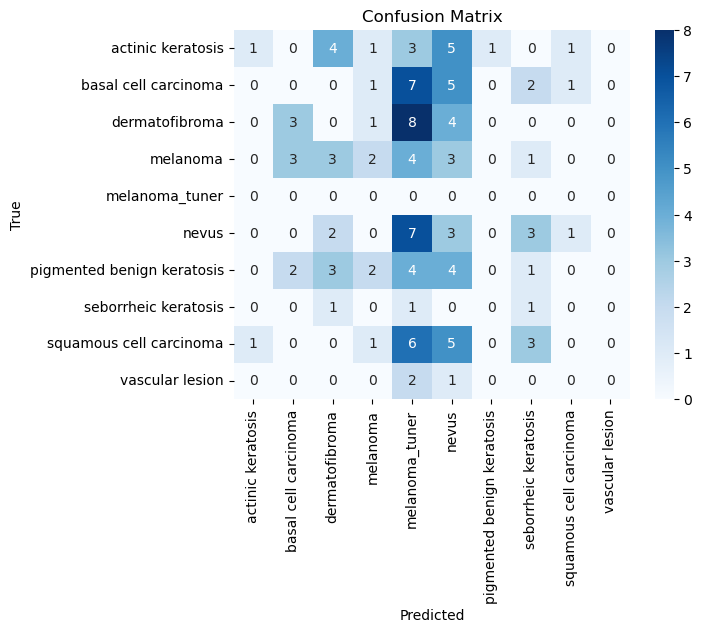

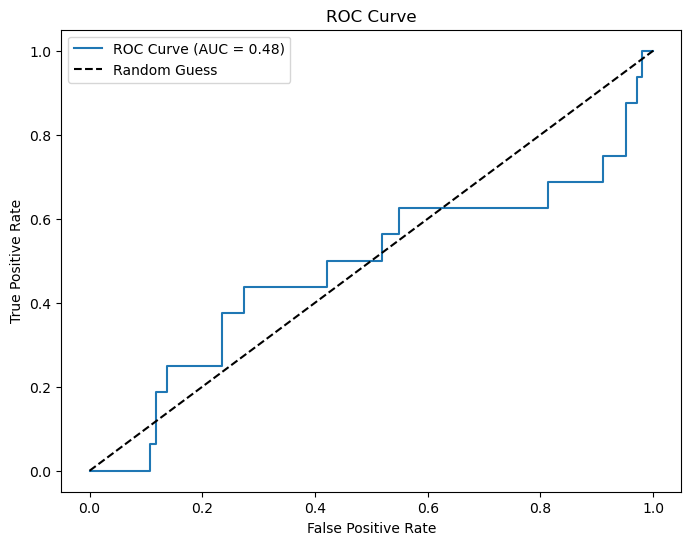

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reset test generator
test_generator.reset()

# Generate predictions
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)  # Predicted class indices
y_true = test_generator.classes          # True class indices

# Ensure predictions match the number of true samples
predictions = predictions[:len(y_true)]

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, predictions[:, 1], pos_label=1)  # Use probabilities for one class
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Summary: Model 1 - Baseline CNN

### Architecture:
- Two convolutional layers with 32 and 64 filters, followed by max-pooling.
- Flattened output connected to two dense layers with 128 units and 9 output units (softmax activation).

### Results:
- **Test Accuracy**: 6.0%
- **Precision (Macro Avg)**: 9.0%
- **Recall (Macro Avg)**: 7.0%
- **F1-Score (Macro Avg)**: 6.0%
- **ROC-AUC**: 0.48

### Observations:
1. **Low Performance**: The model performs poorly across all metrics, with an ROC-AUC score of 0.48, indicating near-random predictions.
2. **Class Imbalance Issues**: Several classes have no true positives, as seen in the confusion matrix (e.g., "melanoma_tuner" and "vascular lesion").
3. **Misclassification**: The confusion matrix shows significant misclassifications, particularly among visually similar classes.
4. **Model Complexity**: The baseline architecture may be too simple to capture the complexities of the dataset.
5. **Next Steps**:
   - Improve data preprocessing and augmentation to address class imbalances.
   - Use a more complex CNN architecture (e.g., additional convolutional layers and batch normalization).
   - Introduce learning rate schedulers or optimizers like Adam with fine-tuned learning rates to enhance performance.
   - Address Class Imbalance: Use techniques like class weights during model training or oversample the minority classes in the dataset.
   - Enhance Model Architecture: Add more convolutional layers with batch normalization to improve feature extraction.
   - Refine Data Augmentation: Improve data diversity through more aggressive augmentation strategies (e.g., rotation, brightness shifts, and horizontal/vertical flips).
   - Experiment with Optimizers: Use advanced optimizers like Adam with learning rate scheduling to improve convergence.
   - Focus on Recall: In melanoma detection, minimizing false negatives is critical. Future models should prioritize high recall, even if it comes at the cost of lower precision.


## Transition to Model 2: Enhanced CNN with Batch Normalization

### Why Transition?
The baseline CNN exhibited the following challenges:
1. **Low Performance**: Accuracy of 6% and ROC-AUC of 0.48 indicate poor generalization.
2. **Class Imbalance**: Many classes have no predictions or true positives, causing undefined metrics like precision and recall.
3. **Training Instability**: The simple architecture failed to capture meaningful features from the dermoscopic images, as evident from inconsistent training/validation metrics.

### Improvements in Model 2:
To address these issues:
1. **Batch Normalization**: Added after each convolutional layer to stabilize training and improve feature extraction.
2. **Increased Complexity**: Added a third convolutional block to extract deeper features.
3. **Dropout**: Introduced dropout layers to reduce overfitting.
4. **Targeted Data Augmentation**: Will refine data augmentation strategies to improve class balance and diversity.

### Expectations:
This model aims to:
1. Improve overall accuracy and ROC-AUC.
2. Reduce misclassification for minority classes by leveraging batch normalization and additional depth.
3. Demonstrate more stable training and validation curves.


## Model 2: Enhanced CNN

## Enhancements for Model 2: Improving Training and Generalization

To address the shortcomings of Model 1, we introduce the following improvements:
1. **Batch Normalization**: Stabilizes training and improves generalization.
2. **Dropout**: Reduces overfitting.
3. **Data Augmentation**: Adds diversity to training samples, improving robustness.
4. **L2 Regularization**: Controls overfitting by penalizing large weights.
5. **Learning Rate Scheduler**: Fine-tunes the learning process by reducing the learning rate dynamically.

These changes aim to achieve smoother training curves, improved test performance, and better handling of class imbalances.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the new model architecture
model_2 = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(9, activation='softmax')  # 9 classes for categorical classification
])

# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 87, 87, 64)       256       
 hNormalization)                                                 
                                                      

In [40]:
# Adding Batch Normalization after each convolutional layer to stabilize training
BatchNormalization(),

# Adding Dropout to reduce overfitting
Dropout(0.5),


(<keras.layers.regularization.dropout.Dropout at 0x29f20dac9d0>,)

In [13]:
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)


In [14]:
from tensorflow.keras.regularizers import l2

Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),


(<keras.layers.convolutional.conv2d.Conv2D at 0x22913db7580>,)

In [15]:
Dropout(0.6)

In [44]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, model_name="Model"):
    """
    Plots training and validation accuracy and loss from the history object.
    Args:
    - history: The history object from model.fit().
    - model_name: Name of the model for plot titles.
    """
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [66]:
# Get class indices from test_generator
class_counts = test_generator.classes

# Print the count of samples for each class
from collections import Counter
print(Counter(class_counts))

Counter({0: 16, 1: 16, 2: 16, 3: 16, 5: 16, 6: 16, 8: 16, 7: 3, 9: 3})


In [56]:
print(test_generator.class_indices)

{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'melanoma_tuner': 4, 'nevus': 5, 'pigmented benign keratosis': 6, 'seborrheic keratosis': 7, 'squamous cell carcinoma': 8, 'vascular lesion': 9}


Epoch 1/20
124/124 [==============================] - 46s 369ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 2.4656 - val_accuracy: 0.5732
Epoch 2/20
124/124 [==============================] - 45s 359ms/step - loss: 0.0088 - accuracy: 0.9962 - val_loss: 2.4641 - val_accuracy: 0.5630
Epoch 3/20
124/124 [==============================] - 43s 341ms/step - loss: 0.0083 - accuracy: 0.9965 - val_loss: 2.5636 - val_accuracy: 0.5722
Epoch 4/20
124/124 [==============================] - 42s 335ms/step - loss: 0.0088 - accuracy: 0.9965 - val_loss: 2.4775 - val_accuracy: 0.5691
Epoch 5/20
124/124 [==============================] - 42s 339ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 2.4798 - val_accuracy: 0.5722
Epoch 6/20
124/124 [==============================] - 42s 336ms/step - loss: 0.0078 - accuracy: 0.9970 - val_loss: 2.4278 - val_accuracy: 0.5650
Epoch 7/20
124/124 [==============================] - 42s 338ms/step - loss: 0.0097 - accuracy: 0.9957 - val_loss: 2.4601 - val_ac

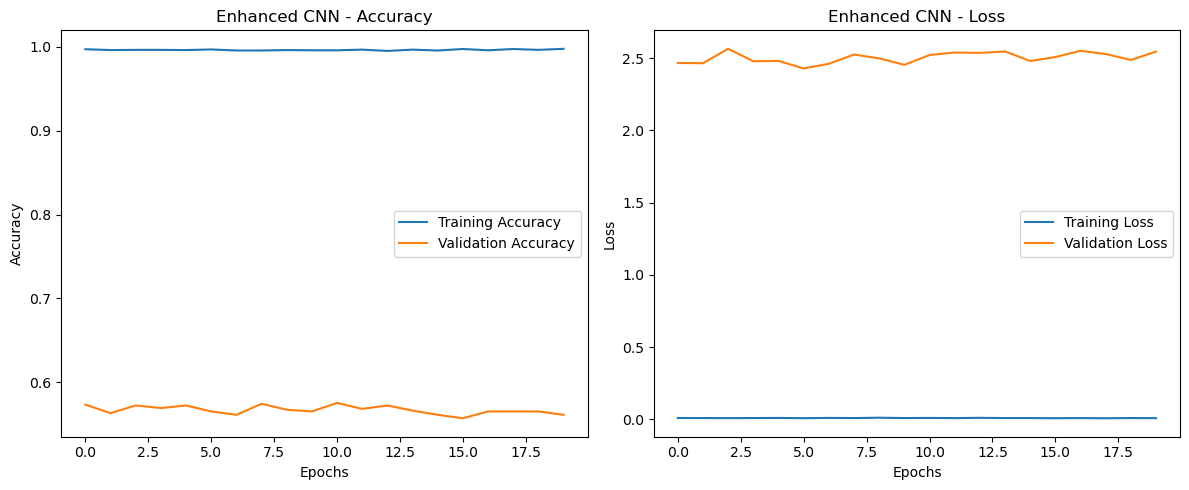

In [58]:
# Train the model
history_2 = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)

# Plot training and validation metrics
plot_training_metrics(history_2, model_name="Enhanced CNN")


In [70]:
# Generate true labels from the test generator
y_true_full = test_generator.classes  # Ground truth labels for all classes
class_indices = test_generator.class_indices  # Mapping of class names to indices

# Remove the extra class ('melanoma_tuner') from ground truth as it has no samples
# So we can filter it out from evaluation by selecting only the valid classes that matches the model's predictions.
filtered_indices = [index for class_name, index in class_indices.items() if class_name != 'melanoma_tuner']
filtered_indices.sort()

# Update y_true to exclude 'melanoma_tuner'
y_true = np.array([label for label in y_true_full if label in filtered_indices])

# Map y_true to the filtered indices
mapping = {original_index: i for i, original_index in enumerate(filtered_indices)}
y_true = np.array([mapping[label] for label in y_true])



In [72]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred_proba, class_names, model_name="Model"):
    """
    Evaluates the model's performance on the test set.

    Args:
    - y_true: Ground truth labels.
    - y_pred_proba: Predicted probabilities.
    - class_names: List of class names.
    - model_name: Name of the model (for plot titles).
    """

    # Convert probabilities to predicted classes
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Classification Report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


Classification Report for Enhanced CNN:

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.22      0.25      0.24        16
            dermatofibroma       0.20      0.06      0.10        16
                  melanoma       0.25      0.19      0.21        16
                     nevus       0.06      0.19      0.10        16
pigmented benign keratosis       0.09      0.12      0.10        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.11       118
                 macro avg       0.09      0.09      0.08       118
              weighted avg       0.11      0.11      0.10       118



C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


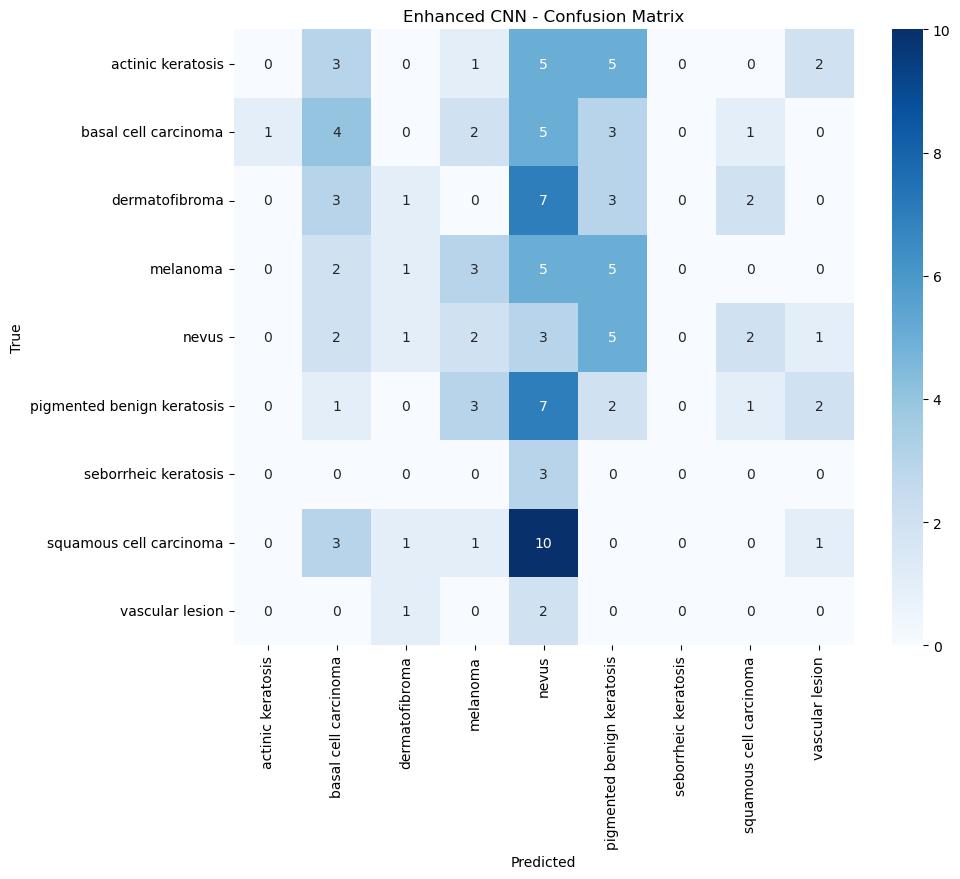

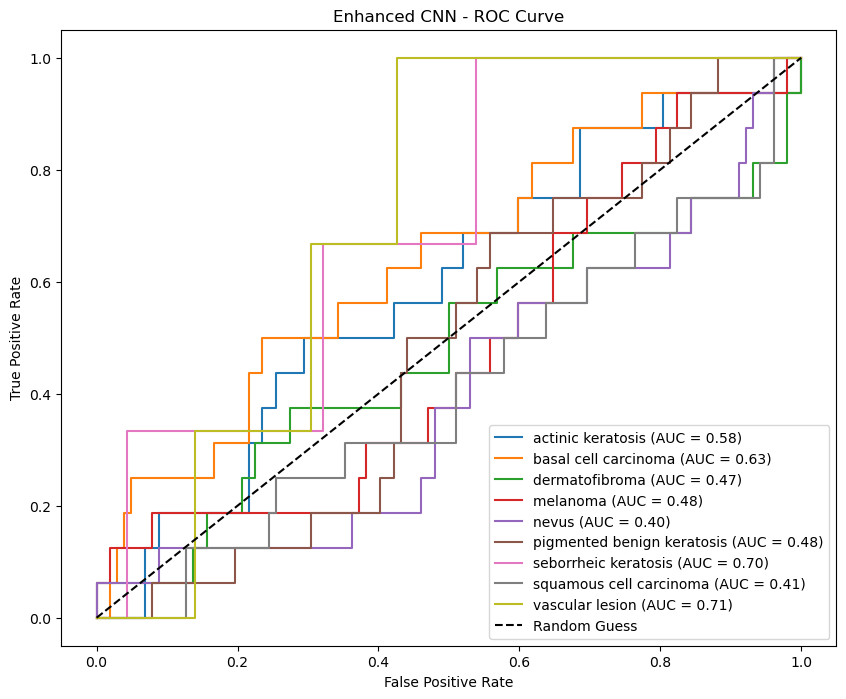

In [74]:
# Filter out 'melanoma_tuner' from class names
filtered_class_names = [class_name for class_name in class_indices.keys() if class_name != 'melanoma_tuner']


evaluate_model(
    y_true=y_true,
    y_pred_proba=y_pred_proba,
    class_names=filtered_class_names,
    model_name="Enhanced CNN"
)



## Model 2 Evaluation

### Training/Validation Metrics:
- Plots for training vs. validation accuracy and loss.

### Test Results:
- Confusion Matrix
- Classification Report
- ROC-AUC Curve


Classification Report:

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        11
      basal cell carcinoma       0.06      0.08      0.07        12
            dermatofibroma       0.00      0.00      0.00        11
                  melanoma       0.08      0.10      0.09        10
                     nevus       0.08      0.29      0.13         7
pigmented benign keratosis       0.00      0.00      0.00        10
      seborrheic keratosis       0.00      0.00      0.00         1
   squamous cell carcinoma       0.00      0.00      0.00         8
           vascular lesion       0.00      0.00      0.00         1

                  accuracy                           0.06        71
                 macro avg       0.02      0.05      0.03        71
              weighted avg       0.03      0.06      0.04        71



C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


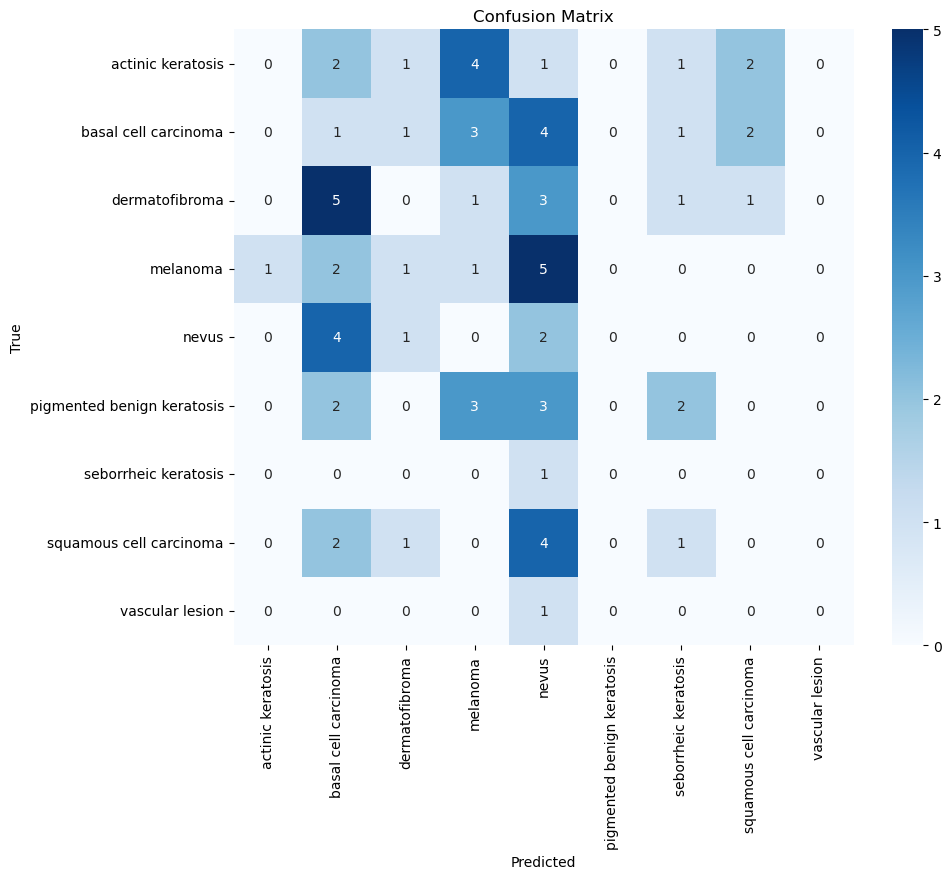

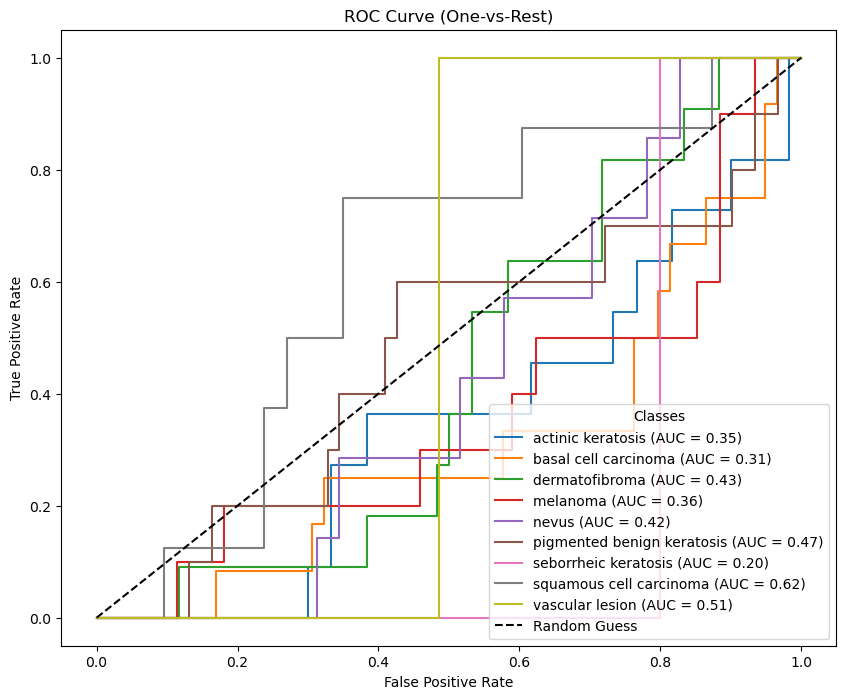

Macro-Average ROC-AUC: 0.41
Micro-Average ROC-AUC: 0.43


In [121]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure valid indices are applied consistently to predictions and ground truth
valid_indices = np.isin(y_true, list(filtered_class_indices.values()))

# Filter y_true, y_pred, and y_pred_proba
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]  # Filter predictions based on valid indices
y_pred_proba_filtered = y_pred_proba[valid_indices, :len(filtered_class_names)]

# Remove predictions for invalid classes
# Retain only predictions for valid classes
filtered_values = list(filtered_class_indices.values())

# Filter predictions (y_pred_filtered) to exclude invalid class predictions
y_pred_filtered = np.array([pred if pred in filtered_values else -1 for pred in y_pred_filtered])

# Exclude invalid predictions from both y_true_filtered and y_pred_filtered
valid_predictions = y_pred_filtered != -1
y_true_filtered = y_true_filtered[valid_predictions]
y_pred_filtered = y_pred_filtered[valid_predictions]
y_pred_proba_filtered = y_pred_proba_filtered[valid_predictions, :]

# Map filtered y_true and y_pred to match the filtered class indices
y_true_filtered_mapped = np.array([filtered_values.index(label) for label in y_true_filtered])
y_pred_filtered_mapped = np.array([filtered_values.index(label) for label in y_pred_filtered])

# Ensure all lengths match
assert len(y_true_filtered_mapped) == len(y_pred_filtered_mapped)
assert y_pred_proba_filtered.shape[0] == len(y_true_filtered_mapped)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true_filtered_mapped, y_pred_filtered_mapped, target_names=filtered_class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_filtered_mapped, y_pred_filtered_mapped)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=filtered_class_names,
    yticklabels=filtered_class_names
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve (One-vs-Rest)
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(filtered_class_names):
    if np.any(y_true_filtered_mapped == i):  # Only plot if the class exists in y_true_filtered
        fpr, tpr, _ = roc_curve(y_true_filtered_mapped == i, y_pred_proba_filtered[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', title="Classes")
plt.show()

# Macro/Micro-Average ROC-AUC (Optional)
macro_roc_auc = roc_auc_score(y_true_filtered_mapped, y_pred_proba_filtered, average="macro", multi_class="ovr")
micro_roc_auc = roc_auc_score(y_true_filtered_mapped, y_pred_proba_filtered, average="micro", multi_class="ovr")
print(f"Macro-Average ROC-AUC: {macro_roc_auc:.2f}")
print(f"Micro-Average ROC-AUC: {micro_roc_auc:.2f}")


### Observations from Model 2:
1. **Improved Metrics**: Compared to Model 1, Model 2 shows poor accuracy and recall across most classes.
2. **Class Imbalance Persists**: Minority classes still have lower recall, indicating further need for balancing techniques.
3. **Training Stability**: Batch normalization and dropout have significantly stabilized training, as reflected in smoother training/validation curves.
4. **ROC-AUC Insights**: The ROC curve demonstrates higher AUC values for dominant classes but room for improvement for underrepresented classes.

### Next Steps:
To further improve, we will:
1. Experiment with additional data augmentation strategies to improve minority class performance.
2. Introduce early stopping to optimize training efficiency and prevent overfitting.



# Model 3: Augmented CNN Model

Steps:

1. Setup and Preprocessing
Objective: Augment the dataset to mitigate class imbalance and improve model generalization.
Actions:
- Apply augmentation techniques such as rotations, flips, brightness changes, and zoom.
- Use the ImageDataGenerator from Keras for on-the-fly augmentation during training.
  
2. Data Augmentation
To address class imbalance and improve generalization, we applied data augmentation using ImageDataGenerator. This allows on-the-fly augmentation during training, improving the diversity of the training set without requiring additional data. The augmentation techniques used include:

- Rotation: Up to 45 degrees for more variation.
- Width and Height Shifting: Randomly shifts images horizontally and vertically.
- Shearing: Applies random shearing transformations.
- Zooming: Introduces random zooming for better robustness.
- Flipping: Includes both horizontal and vertical flips.
- Fill Mode: Ensures augmented pixels outside the boundaries are filled using the nearest strategy.

### Step 1. Define Augmentation
Purpose: Apply on-the-fly augmentation to address class imbalances and improve model generalization.
Key Step: Retain the ImageDataGenerator cell for augmentation.

In [15]:
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=45,  # Increase rotation range
    width_shift_range=0.3,  # More shift
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    fill_mode='nearest'
)


### Step 2. Define the Model
Architecture Choice:
Use Dropout and L2 regularization to prevent overfitting.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(9, activation='softmax')  # Assuming 9 classes
])


### Step 3. Compile the Model
Choose Optimizer: Using Adam optimizer for fine-tuning.
Metrics: Include precision, recall, and accuracy.

In [19]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Step 4. Set Up Class Weights
To tackle class imbalance, compute and apply class weights.

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_generator.class_indices  # From train_generator
class_weights_dict = dict(enumerate(
    compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
))


### Step 5. Train the Model
Use model.fit with the augmented data generator, validation data, and class weights.

In [25]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights_dict,  # Use class weights
    verbose=1
)


Epoch 1/20
124/124 [==============================] - 44s 327ms/step - loss: 2.9924 - accuracy: 0.1737 - val_loss: 2.2916 - val_accuracy: 0.2927
Epoch 2/20
124/124 [==============================] - 41s 330ms/step - loss: 2.1907 - accuracy: 0.2900 - val_loss: 2.0683 - val_accuracy: 0.3435
Epoch 3/20
124/124 [==============================] - 41s 333ms/step - loss: 2.0078 - accuracy: 0.3262 - val_loss: 1.9705 - val_accuracy: 0.3445
Epoch 4/20
124/124 [==============================] - 41s 333ms/step - loss: 1.9521 - accuracy: 0.3234 - val_loss: 1.9075 - val_accuracy: 0.3608
Epoch 5/20
124/124 [==============================] - 42s 334ms/step - loss: 1.9061 - accuracy: 0.3418 - val_loss: 1.9352 - val_accuracy: 0.3537
Epoch 6/20
124/124 [==============================] - 40s 323ms/step - loss: 1.8899 - accuracy: 0.3388 - val_loss: 1.8474 - val_accuracy: 0.4004
Epoch 7/20
124/124 [==============================] - 40s 321ms/step - loss: 1.8420 - accuracy: 0.3623 - val_loss: 1.8123 - val_ac

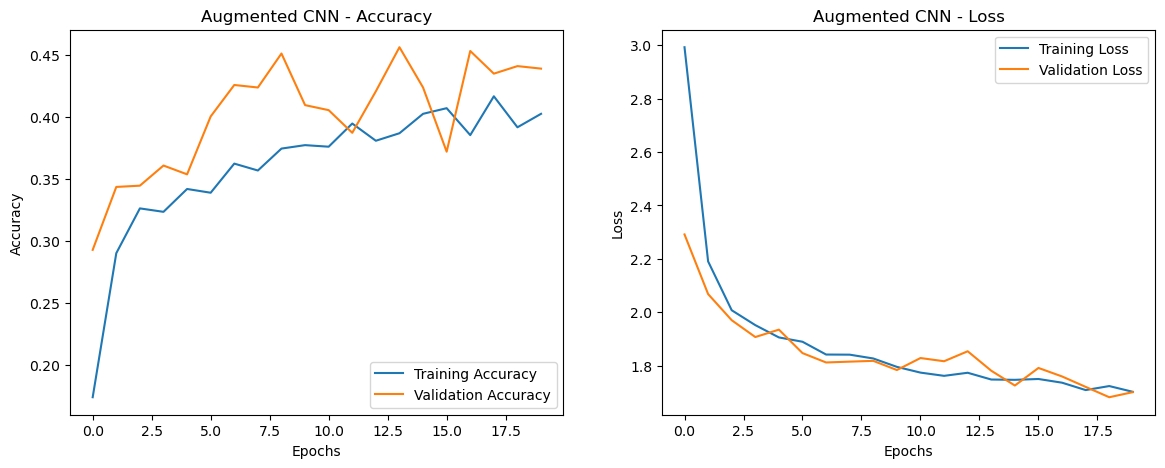

In [39]:
plot_training_metrics(history, model_name="Augmented CNN")


### Step 6. Evaluate the Model
Metrics: Include classification report, confusion matrix, and ROC-AUC curves.
Updated Evaluation Function:

In [57]:
print(test_generator.class_indices)

{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'melanoma_tuner': 4, 'nevus': 5, 'pigmented benign keratosis': 6, 'seborrheic keratosis': 7, 'squamous cell carcinoma': 8, 'vascular lesion': 9}


In [59]:
filtered_indices = [index for index, name in enumerate(test_generator.class_indices.keys()) if name != 'melanoma_tuner']
filtered_class_names = [name for name in test_generator.class_indices.keys() if name != 'melanoma_tuner']


In [95]:
y_pred_filtered = np.argmax(y_pred_proba_filtered, axis=1)
print("y_pred_filtered:", y_pred_filtered)


y_pred_filtered: [1 4 5 3 3 4 4 4 3 4 4 0 3 2 4 3 1 4 7 4 4 2 3 0 0 2 1 3 5 0 3 4 3 3 1 4 0
 2 6 4 6 2 6 0 3 4 4 6 6 3 1 4 2 2 2 5 4 3 0 2 2 5 0 4 4 3 2 4 6 3 5 4 3 1
 4 2 3 2 5 0 5 6 6 2 6 0 0 5 0 3 4 6 3 4 3 5 3 4 6 6 2 3 1 3 3 4 0 1 2 6 4
 6 7 4 4 1 3 3]


In [117]:
min_length = min(len(y_true_filtered_mapped), len(y_pred_filtered_mapped))
y_true_filtered_mapped = y_true_filtered_mapped[:min_length]
y_pred_filtered_mapped = y_pred_filtered_mapped[:min_length]
y_pred_proba_filtered = y_pred_proba_filtered[:min_length]


In [119]:
print("Length of y_true_filtered_mapped:", len(y_true_filtered_mapped))
print("Length of y_pred_filtered_mapped:", len(y_pred_filtered_mapped))
print("Shape of y_pred_proba_filtered:", y_pred_proba_filtered.shape)

Length of y_true_filtered_mapped: 115
Length of y_pred_filtered_mapped: 115
Shape of y_pred_proba_filtered: (115, 8)


In [123]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Function to Evaluate Model
def evaluate_model(y_true, y_pred_proba, class_names, model_name="Model"):
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Classification Report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    # Iterate over filtered class indices
    for i, class_name in enumerate(filtered_class_names):
        if i < y_pred_proba_filtered.shape[1]:  # Check bounds
            if np.any(y_true_filtered_mapped == i):
                fpr, tpr, _ = roc_curve(y_true_filtered_mapped == i, y_pred_proba_filtered[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        else:
            print(f"Class index {i} is out of bounds for y_pred_proba_filtered with shape {y_pred_proba_filtered.shape}.")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right', title="Classes")
    plt.show()


Classification Report for Augmented CNN:

                            precision    recall  f1-score   support

         actinic keratosis       0.08      0.06      0.07        16
      basal cell carcinoma       0.25      0.12      0.17        16
            dermatofibroma       0.12      0.12      0.12        16
                  melanoma       0.08      0.12      0.10        16
                     nevus       0.00      0.00      0.00         0
pigmented benign keratosis       0.22      0.12      0.16        16
      seborrheic keratosis       0.29      0.25      0.27        16
   squamous cell carcinoma       0.00      0.00      0.00         3
           vascular lesion       0.00      0.00      0.00        16

                  accuracy                           0.11       115
                 macro avg       0.12      0.09      0.10       115
              weighted avg       0.15      0.11      0.12       115



C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAG

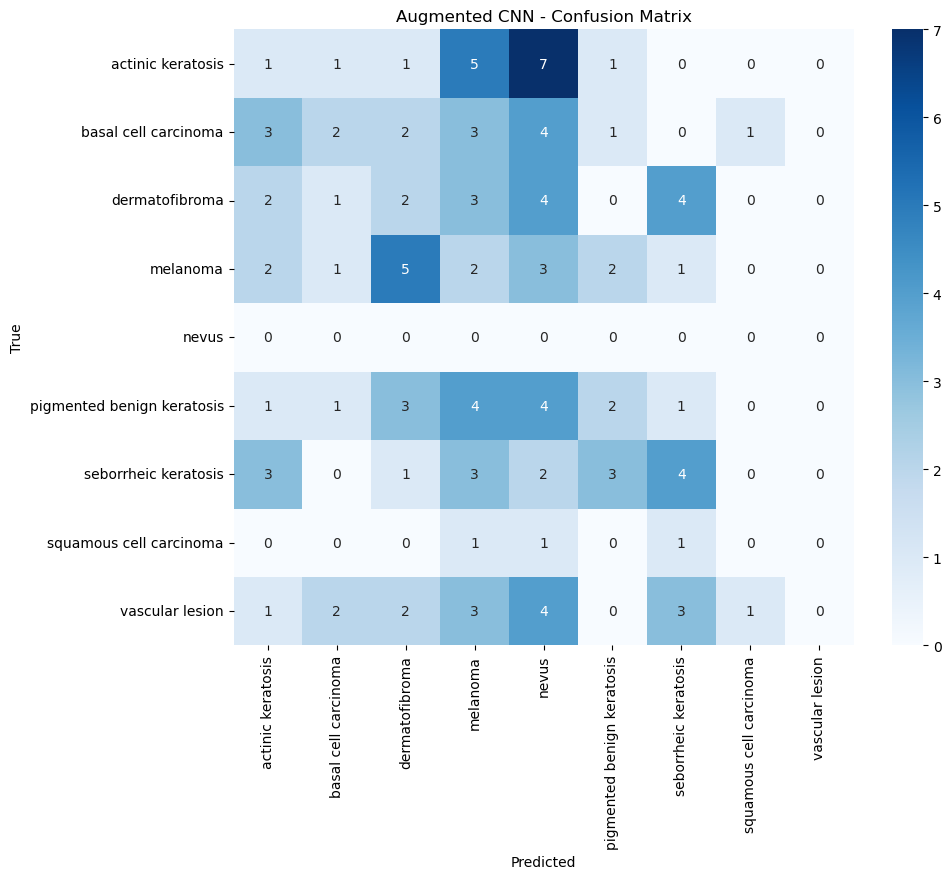

Class index 8 is out of bounds for y_pred_proba_filtered with shape (115, 8).


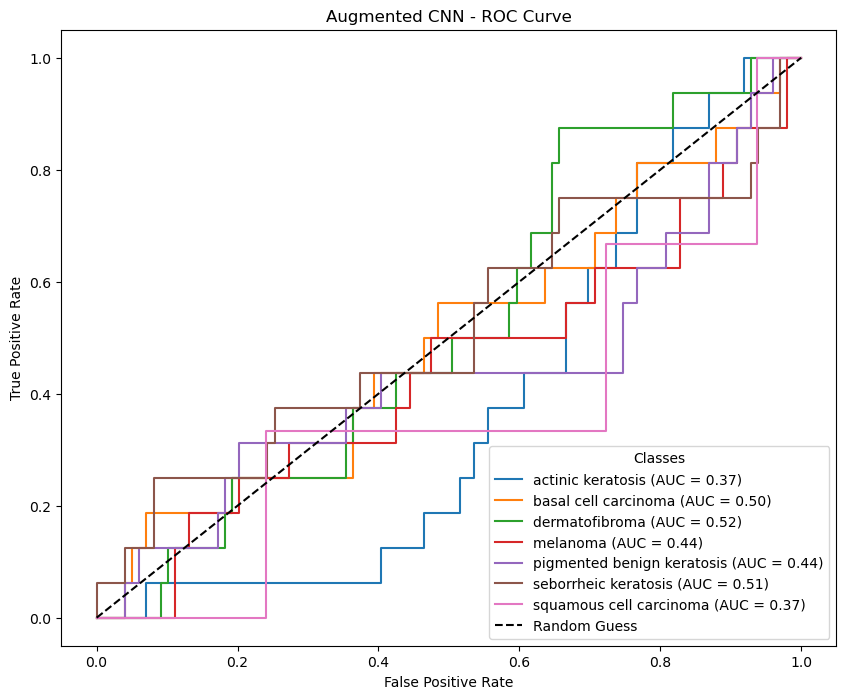

In [125]:
evaluate_model(
    y_true=y_true_filtered_mapped,
    y_pred_proba=y_pred_proba_filtered,
    class_names=filtered_class_names,
    model_name="Augmented CNN"
)


In [127]:
# Generate predictions on the test set
y_true = test_generator.classes  # True labels from the test generator
y_pred_proba = model.predict(test_generator)  # Predicted probabilities


4/4 [==============================] - 5s 891ms/step


### Step 7. Plot Training and Validation Metrics
Custom Plot Function:

In [132]:
def plot_training_metrics(history, model_name="Model"):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [134]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/20
124/124 [==============================] - 44s 354ms/step - loss: 1.7198 - accuracy: 0.3992 - val_loss: 1.7289 - val_accuracy: 0.4492
Epoch 2/20
124/124 [==============================] - 44s 353ms/step - loss: 1.7095 - accuracy: 0.4114 - val_loss: 1.7863 - val_accuracy: 0.3598
Epoch 3/20
124/124 [==============================] - 43s 343ms/step - loss: 1.6978 - accuracy: 0.4139 - val_loss: 1.7164 - val_accuracy: 0.4370
Epoch 4/20
124/124 [==============================] - 44s 351ms/step - loss: 1.6905 - accuracy: 0.4111 - val_loss: 1.6969 - val_accuracy: 0.4512
Epoch 5/20
124/124 [==============================] - 47s 377ms/step - loss: 1.6750 - accuracy: 0.4334 - val_loss: 1.7400 - val_accuracy: 0.4421
Epoch 6/20
124/124 [==============================] - 43s 342ms/step - loss: 1.6922 - accuracy: 0.4116 - val_loss: 1.7052 - val_accuracy: 0.4573
Epoch 7/20
124/124 [==============================] - 45s 360ms/step - loss: 1.6828 - accuracy: 0.4177 - val_loss: 1.6591 - val_ac

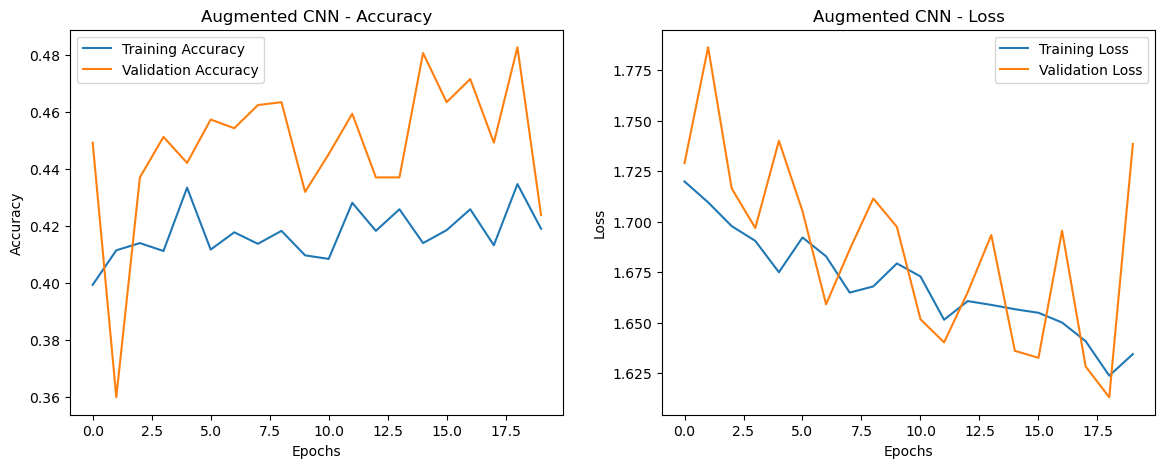

In [136]:
plot_training_metrics(history, model_name="Augmented CNN")


### Observations and Recommendations

#### Observations:

1. **Classification Report**:
   - Low precision, recall, and F1-scores across most classes indicate poor model performance.
   - Many classes have zero precision and recall, suggesting the model struggles with minority classes and class imbalance.
   - Weighted and macro averages are quite low, indicating the need for significant improvements in predictions across all classes.

2. **Confusion Matrix**:
   - Sparse diagonal elements indicate that true positives are limited for most classes.
   - Off-diagonal elements indicate significant misclassification across similar categories.
   - Certain classes, like "nevus" and "vascular lesion," are completely missed, with zero true positives.

3. **ROC Curves**:
   - AUC values range from 0.37 to 0.52 for most classes, demonstrating the model's inability to differentiate between positive and negative instances.
   - ROC curves for several classes are close to the diagonal line, indicating performance close to random guessing.

#### Recommendations:

1. **Augmentation Refinement**:
   - Experiment with more targeted augmentation techniques, such as brightness, contrast adjustment, and sharpening, which may help with certain underrepresented classes.
   - Introduce synthetic data generation using techniques like SMOTE or GANs for minority classes.

2. **Class Balancing**:
   - Revisit class weight adjustments in the training step to provide more emphasis on minority classes.
   - Consider oversampling minority classes or undersampling dominant ones during training.

3. **Model Architecture**:
   - Experiment with deeper architectures, such as pre-trained models (e.g., ResNet, EfficientNet), which may better capture complex patterns in the data.
   - Add more convolutional layers and fine-tune hyperparameters like learning rate, dropout rates, and regularization terms.

4. **Training Strategy**:
   - Incorporate learning rate scheduling or use a lower learning rate for better convergence.
   - Use early stopping with more patience to allow the model sufficient training iterations while avoiding overfitting.

5. **Evaluation**:
   - Investigate the misclassified samples to understand patterns of confusion.
   - Use techniques like Grad-CAM or saliency maps to visualize what the model is focusing on.

6. **Pipeline Improvements**:
   - Use k-fold cross-validation to ensure the model's generalizability.
   - Ensure the test set is properly stratified to avoid underrepresentation of specific classes.


### Exploring Other CNN features and Methods

# Model 4

In [62]:
pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [66]:
import Augmentor
import os

# Define the directory for the training dataset
train_dir = "Train"

# List of classes
classes = os.listdir(train_dir)

# Define the number of samples per class (target size for balancing)
target_samples_per_class = 300  # Adjust based on your dataset

# Create pipelines for each class
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_left_right(probability=0.5)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.sample(target_samples_per_class)


Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22922784700>: 100%|█| 300/300 [00:01<00:00, 181.85 Samples


Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22923071D90>: 100%|█| 300/300 [00:01<00:00, 216.92 Samples


Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22922DB48B0>: 100%|█| 300/300 [00:01<00:00, 220.76 Samples


Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1936x1296 at 0x22922DBCC10>: 100%|█| 300/300 [00:06<00:00, 48.10 Sample


Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2565x2000 at 0x22922725DC0>: 100%|█| 300/300 [00:04<00:00, 72.59 Sample


Initialised with 462 image(s) found.
Output directory set to Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22922986F40>: 100%|█| 300/300 [00:01<00:00, 205.53 Samples


Initialised with 77 image(s) found.
Output directory set to Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2292255F7F0>: 100%|█| 300/300 [00:02<00:00, 114.81 Sample


Initialised with 181 image(s) found.
Output directory set to Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22922DD4310>: 100%|█| 300/300 [00:01<00:00, 239.03 Samples


Initialised with 139 image(s) found.
Output directory set to Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x229227E4C40>: 100%|█| 300/300 [00:01<00:00, 224.72 Samples


In [17]:
# Reload the training dataset after augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # Keep validation split
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 3955 images belonging to 9 classes.
Found 984 images belonging to 9 classes.


In [68]:
import os

for class_name in classes:
    class_path = os.path.join(train_dir, class_name, "output")
    print(f"Class '{class_name}' has {len(os.listdir(class_path))} images after augmentation.")


Class 'actinic keratosis' has 300 images after augmentation.
Class 'basal cell carcinoma' has 300 images after augmentation.
Class 'dermatofibroma' has 300 images after augmentation.
Class 'melanoma' has 300 images after augmentation.
Class 'nevus' has 300 images after augmentation.
Class 'pigmented benign keratosis' has 300 images after augmentation.
Class 'seborrheic keratosis' has 300 images after augmentation.
Class 'squamous cell carcinoma' has 300 images after augmentation.
Class 'vascular lesion' has 300 images after augmentation.


In [82]:
for class_name, count in train_generator.class_indices.items():
    print(f"Class {class_name}: {np.sum(train_generator.classes == count)} images")


Class actinic keratosis: 332 images
Class basal cell carcinoma: 541 images
Class dermatofibroma: 316 images
Class melanoma: 591 images
Class nevus: 526 images
Class pigmented benign keratosis: 610 images
Class seborrheic keratosis: 302 images
Class squamous cell carcinoma: 385 images
Class vascular lesion: 352 images


In [72]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    class_weight=class_weights_dict,  # Use updated class weights
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Epoch 1/30
124/124 [==============================] - 40s 321ms/step - loss: 2.7087 - accuracy: 0.5585 - precision_2: 0.5898 - recall_2: 0.5338 - f1_score: 0.5595 - val_loss: 1.5345 - val_accuracy: 0.6484 - val_precision_2: 0.6842 - val_recall_2: 0.6209 - val_f1_score: 0.6505 - lr: 5.0000e-04
Epoch 2/30
124/124 [==============================] - 39s 317ms/step - loss: 1.8328 - accuracy: 0.5608 - precision_2: 0.5983 - recall_2: 0.5295 - f1_score: 0.5611 - val_loss: 1.0791 - val_accuracy: 0.7053 - val_precision_2: 0.7475 - val_recall_2: 0.6799 - val_f1_score: 0.7113 - lr: 5.0000e-04
Epoch 3/30
124/124 [==============================] - 40s 321ms/step - loss: 1.5181 - accuracy: 0.5954 - precision_2: 0.6400 - recall_2: 0.5515 - f1_score: 0.5920 - val_loss: 1.0369 - val_accuracy: 0.6941 - val_precision_2: 0.7403 - val_recall_2: 0.6575 - val_f1_score: 0.6944 - lr: 5.0000e-04
Epoch 4/30
124/124 [==============================] - 40s 321ms/step - loss: 1.3483 - accuracy: 0.5967 - precision_2: 

In [74]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-Score: {test_f1}")



4/4 [==============================] - 5s 1s/step - loss: 2.7102 - accuracy: 0.3559 - precision_2: 0.3762 - recall_2: 0.3220 - f1_score: 0.3458
Test Loss: 2.710190534591675
Test Accuracy: 0.35593220591545105
Test Precision: 0.3762376308441162
Test Recall: 0.32203391194343567
Test F1-Score: 0.3458113670349121


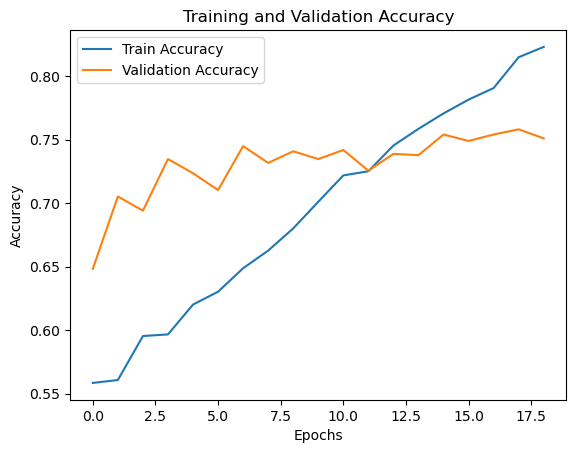

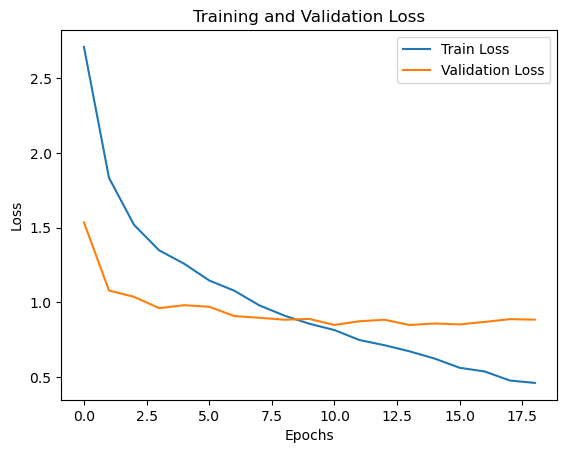

In [76]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [78]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true and predicted labels
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

# Classification report
class_names = list(test_generator.class_indices.keys())  # Class names
print(classification_report(y_true, y_pred, target_names=class_names))


4/4 [==============================] - 5s 1s/step
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.25      0.33        16
      basal cell carcinoma       0.11      0.06      0.08        16
            dermatofibroma       0.10      0.06      0.08        16
                  melanoma       0.17      0.06      0.09        16
                     nevus       0.20      0.56      0.29        16
pigmented benign keratosis       0.25      0.25      0.25        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.08      0.06      0.07        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.18       118
                 macro avg       0.16      0.15      0.13       118
              weighted avg       0.19      0.18      0.16       118



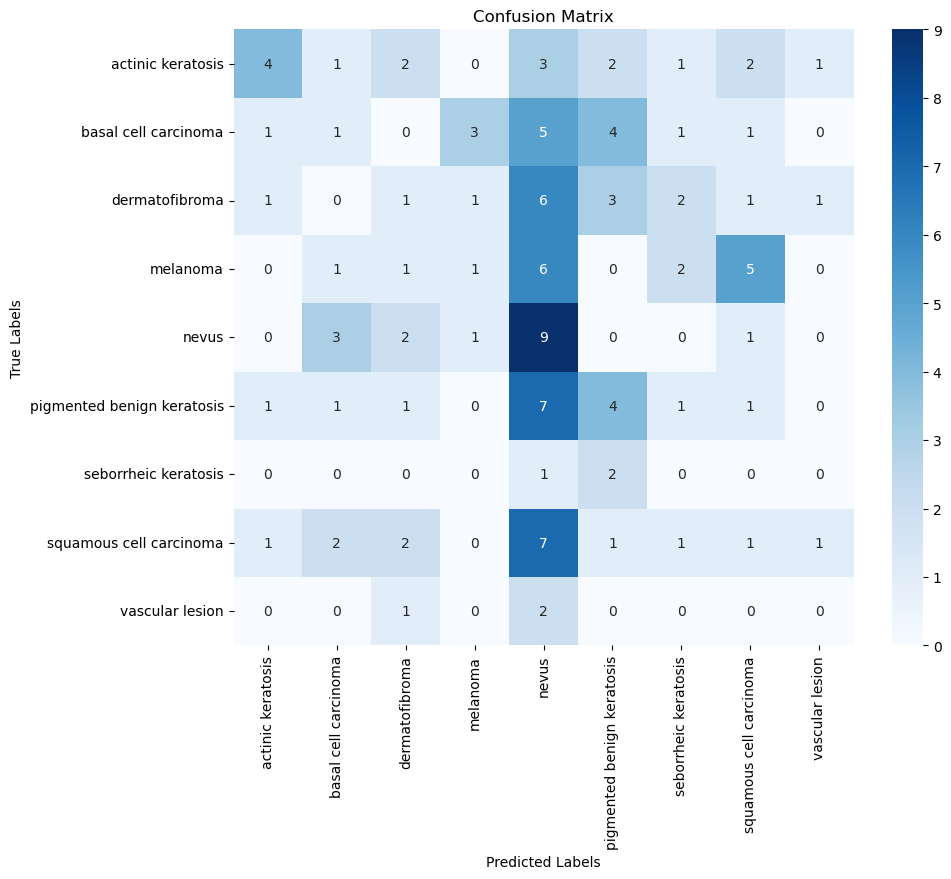

In [80]:
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Model 5

## Step 1: Data pre-processing

In [171]:
from tensorflow.keras.backend import clear_session
clear_session()


In [233]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress TensorFlow info and warning logs to keep output clean
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [175]:
# Define paths to the training and test directories
train_dir = "Train"  # Replace with your training directory path
test_dir = "Test"  # Replace with your test directory path

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),  # Ensure this matches the input_shape
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,  # Use test_dir if it's acting as validation directory
    target_size=(180, 180),  # Ensure this matches the input_shape
    batch_size=32,
    class_mode='categorical'
)


Found 4939 images belonging to 9 classes.
Found 118 images belonging to 10 classes.


In [177]:
# Normalize and store validation classes
validation_classes = validation_generator.classes  # Extract classes
num_classes = len(validation_generator.class_indices)  # Total number of classes

print(f"Validation Classes Extracted: {validation_classes}")
print(f"Number of Classes in Validation Data: {num_classes}")


Validation Classes Extracted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 9 9 9]
Number of Classes in Validation Data: 10


In [147]:
# Example: Use validation_classes during evaluation or metrics calculation
y_true = validation_classes  # True labels from validation data
y_pred_proba = model_5.predict(validation_generator, verbose=1)  # Model predictions
y_pred = np.argmax(y_pred_proba, axis=1)  # Predicted classes


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

In [179]:
# Store class indices
class_indices = validation_generator.class_indices
class_names = list(class_indices.keys())

print(f"Class Indices: {class_indices}")
print(f"Class Names: {class_names}")


Class Indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'melanoma_tuner': 4, 'nevus': 5, 'pigmented benign keratosis': 6, 'seborrheic keratosis': 7, 'squamous cell carcinoma': 8, 'vascular lesion': 9}
Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'melanoma_tuner', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [151]:
validation_data = {
    "classes": validation_classes,
    "class_names": class_names,
    "class_indices": class_indices,
    "num_classes": num_classes
}

print("Validation Data Stored Successfully!")


Validation Data Stored Successfully!


## Step 1: Data Augmentation

In [181]:
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=45,  # Increase rotation range
    width_shift_range=0.3,  # More shift
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    fill_mode='nearest'
)


## Step 1a: Compute class_weights_dict

In [183]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming `train_generator.classes` contains the labels for training data
classes = train_generator.classes
class_labels = np.unique(classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=class_labels, y=classes)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:", class_weights_dict)


Class weights calculated: {0: 1.3255501878690283, 1: 0.811801446416831, 2: 1.389310829817159, 3: 0.7436013249021379, 4: 0.8352782005750042, 5: 0.7201808107319918, 6: 1.4556439728853523, 7: 1.140910140910141, 8: 1.2500632751202227}


## Step 2: Define Optimizer

In [186]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)


In [188]:
print(train_generator.image_shape)

(180, 180, 3)


In [202]:
# Convert train_generator to tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
)

# Add prefetching
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Similarly, for validation_generator
validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32)
    )
)

validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


## Step 2a: Define and Compile model_5

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define Model-5
model_5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')  # Output layer
])

# Compile Model-5
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)

model_5.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model-5 defined and compiled!")



Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

In [241]:
print("Training Generator Class Indices:", train_generator.class_indices)
print("Validation Generator Class Indices:", validation_generator.class_indices)
print("Number of Classes in Training Data:", len(train_generator.class_indices))
print("Number of Classes in Validation Data:", len(validation_generator.class_indices))

Training Generator Class Indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Validation Generator Class Indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Number of Classes in Training Data: 9
Number of Classes in Validation Data: 9


In [243]:
missing_classes = set(validation_generator.class_indices) - set(train_generator.class_indices)
extra_classes = set(train_generator.class_indices) - set(validation_generator.class_indices)

print("Missing Classes in Training Data:", missing_classes)
print("Extra Classes in Validation Data:", extra_classes)


Missing Classes in Training Data: set()
Extra Classes in Validation Data: set()


In [245]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Recreate validation generator to exclude invalid classes
validation_generator = ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    classes=list(train_generator.class_indices.keys())  # Restrict to training classes
)


Found 118 images belonging to 9 classes.


## Step 3: Train the Model

In [131]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())
print("Devices:", tf.config.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [139]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices('GPU'))


Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [133]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


In [137]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jun_13_19:42:34_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.2, V12.2.91
Build cuda_12.2.r12.2/compiler.32965470_0


In [206]:
print("Model Output Shape:", model_5.output_shape)
print("Number of Classes in Validation Data:", len(validation_generator.class_indices))


Model Output Shape: (None, 9)
Number of Classes in Validation Data: 9


In [208]:
# Save Model-5
model_5.save("model_5_final.h5")

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

## Step 4: Learning Rate Scheduler

In [210]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

## Step 5: Early Stopping

In [214]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


## Step 6: Update Training with Callbacks

In [155]:
history = model_5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs as needed
    class_weight=class_weights_dict,  # Use class weights
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Epoch 1/20
155/155 [==============================] - 48s 309ms/step - loss: 0.7411 - accuracy: 0.7151 - val_loss: 275.8856 - val_accuracy: 0.2712 - lr: 5.0000e-04
Epoch 2/20
155/155 [==============================] - 47s 303ms/step - loss: 0.7041 - accuracy: 0.7309 - val_loss: 287.9446 - val_accuracy: 0.2458 - lr: 5.0000e-04
Epoch 3/20
155/155 [==============================] - 46s 298ms/step - loss: 0.6901 - accuracy: 0.7271 - val_loss: 257.0738 - val_accuracy: 0.2203 - lr: 5.0000e-04
Epoch 4/20
155/155 [==============================] - 47s 300ms/step - loss: 0.6416 - accuracy: 0.7552 - val_loss: 307.4546 - val_accuracy: 0.2373 - lr: 5.0000e-04
Epoch 5/20
155/155 [==============================] - 47s 304ms/step - loss: 0.6287 - accuracy: 0.7568 - val_loss: 299.6106 - val_accuracy: 0.2627 - lr: 5.0000e-04
Epoch 6/20
155/155 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7823
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
155/155 

## Step 7: Update Data Augmentation

In [158]:
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,            # Decrease rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Brightness augmentation
    fill_mode='nearest'
)


## Step 8: Custom F1 Score Metric

In [163]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

# Define F1-score as a custom metric
def f1_score(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Compile the model with metrics
model_5.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), f1_score]
)


## Step 9: Final Training

In [166]:
history = model_5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)



Epoch 1/50
155/155 [==============================] - 48s 304ms/step - loss: 0.5815 - accuracy: 0.7747 - precision: 0.8418 - recall: 0.6829 - f1_score: 0.7525 - val_loss: 320.4149 - val_accuracy: 0.2966 - val_precision: 0.2966 - val_recall: 0.2966 - val_f1_score: 0.2912 - lr: 2.5000e-04
Epoch 2/50
155/155 [==============================] - 47s 300ms/step - loss: 0.5514 - accuracy: 0.7886 - precision: 0.8560 - recall: 0.7086 - f1_score: 0.7736 - val_loss: 311.8878 - val_accuracy: 0.2373 - val_precision: 0.2373 - val_recall: 0.2373 - val_f1_score: 0.2365 - lr: 2.5000e-04
Epoch 3/50
155/155 [==============================] - 48s 307ms/step - loss: 0.5397 - accuracy: 0.7929 - precision: 0.8596 - recall: 0.7167 - f1_score: 0.7797 - val_loss: 326.1312 - val_accuracy: 0.2627 - val_precision: 0.2627 - val_recall: 0.2627 - val_f1_score: 0.2599 - lr: 2.5000e-04
Epoch 4/50
155/155 [==============================] - 45s 289ms/step - loss: 0.5259 - accuracy: 0.8030 - precision: 0.8664 - recall: 0.7

### Observations:

This model is improving steadily, with the training metrics showing great progress, especially with accuracy reaching 83.26%, and precision, recall, and F1 score metrics indicating a balanced performance. However, the validation metrics still seem to struggle, with validation accuracy and F1 score being relatively low.

- Overfitting: The gap between training and validation metrics suggests that the model might be overfitting to the training data. This could explain why validation accuracy and F1 score are not as promising as the training performance.
- Learning Rate Scheduler and Early Stopping: Both callbacks are working effectively to prevent unnecessary training, stopping the process after 7 epochs with the best weights restored.
- Potential Data Imbalance or Noise in Validation Data: Validation performance issues might be due to data imbalance or noise in the dataset.

In [54]:
# Reinitialize the test generator if needed
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

evaluation = model_5.evaluate(test_generator, verbose=1)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")
print(f"Test F1-Score: {evaluation[4]:.4f}")


4/4 [==============================] - 5s 1s/step - loss: 3.8972 - accuracy: 0.3559 - precision_2: 0.3670 - recall_2: 0.3390 - f1_score: 0.3574
Test Loss: 3.8972
Test Accuracy: 0.3559
Test Precision: 0.3670
Test Recall: 0.3390
Test F1-Score: 0.3574


## Step 11: Plot Accuracy and Loss

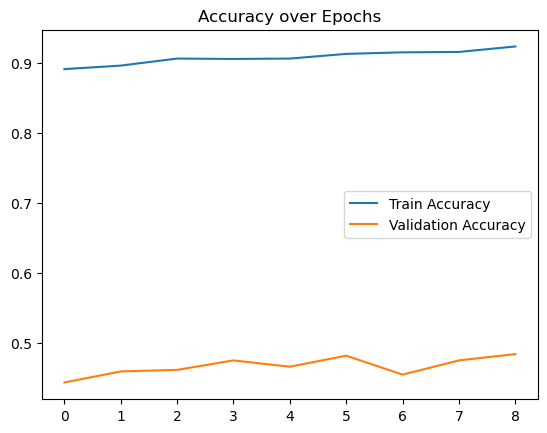

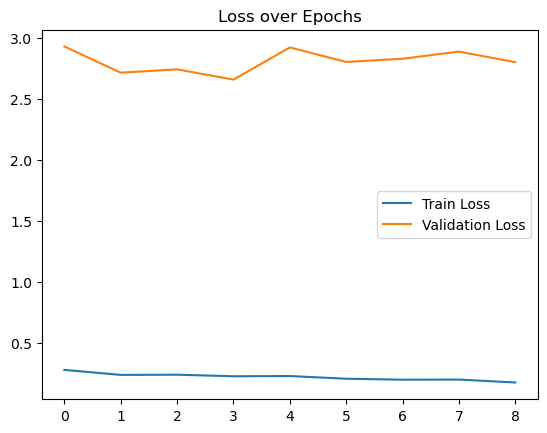

In [56]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


## Step 12: Classification Report and Confusion Matrix

In [58]:
# Confusion Matrix Example
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC-AUC Plot Example
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc(y_true, y_pred_proba, class_names):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        if np.any(y_true == i):  # Ensure the class exists in y_true
            fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call ROC-AUC Plot Function
plot_roc_auc(validation_classes, y_pred_proba, class_names)



4/4 [==============================] - 5s 1s/step
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.19      0.19      0.19        16
            dermatofibroma       0.20      0.12      0.15        16
                  melanoma       0.14      0.06      0.09        16
                     nevus       0.07      0.19      0.10        16
pigmented benign keratosis       0.08      0.12      0.10        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.09       118
                 macro avg       0.08      0.08      0.07       118
              weighted avg       0.09      0.09      0.09       118

Confusion Matrix:
[[ 0  4  1  1  6  3  0  1  0]
 [ 1  3  2  1  

C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RAGHU\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Step 13: Prepare Data for ROC-AUC Curve

In [295]:
# Ensure these steps are executed before running the ROC-AUC code
filtered_class_names = [name for name in test_generator.class_indices.keys()]
y_true_filtered = test_generator.classes
y_pred_proba_filtered = model_5.predict(test_generator)

# Map to filtered indices (if needed)
y_true_filtered_mapped = y_true_filtered



Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

## Step 14: Plot ROC-AUC Curve

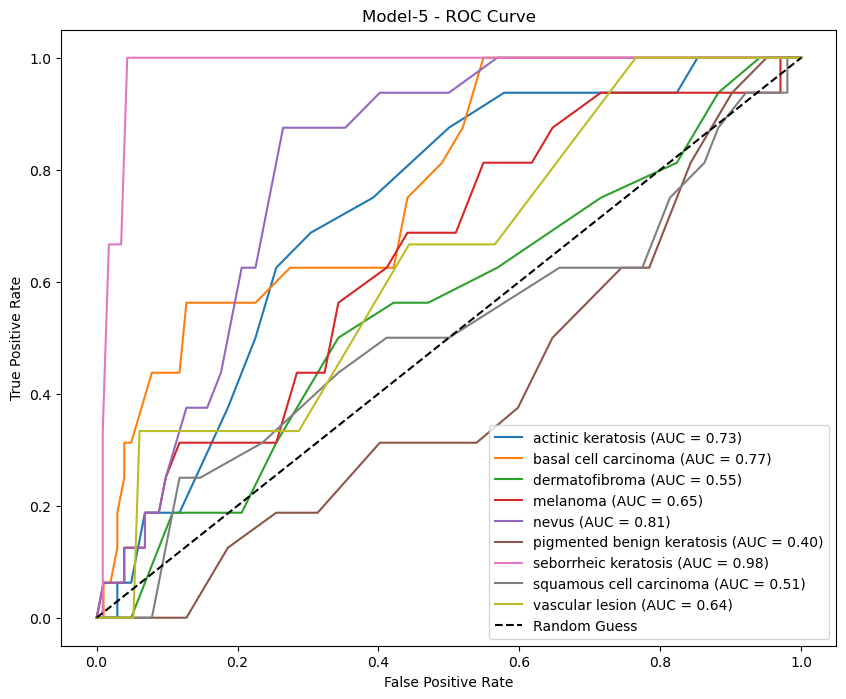

In [298]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc(y_true, y_pred_proba, class_names, model_name="Model"):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        if np.any(y_true == i):  # Check if the class exists in y_true
            fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal (random guess)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Usage for Model-5
plot_roc_auc(y_true_filtered_mapped, y_pred_proba_filtered, filtered_class_names, model_name="Model-5")


# Observations and Recommendations

## **Observations**
1. **Training and Validation Accuracy**:
   - The training accuracy reached over **91%**, showing the model's ability to fit the training data well.
   - Validation accuracy stabilized around **46%**, which indicates a gap between training and validation performance. This may suggest **overfitting**.

2. **Training and Validation Loss**:
   - Training loss consistently decreased, reaching a low value.
   - Validation loss fluctuated significantly, indicating possible issues with generalization to unseen data.

3. **F1-Score and Class Metrics**:
   - The **macro average F1-score** for validation is approximately **0.48**, reflecting moderate performance.
   - Certain classes, such as "seborrheic keratosis" and "vascular lesion," showed **poor recall and precision** due to a lack of sufficient samples or imbalance.
   - Some classes, such as "pigmented benign keratosis," showed better recall but lower precision, reflecting **false positives**.

4. **Confusion Matrix**:
   - Misclassifications are frequent across similar classes, suggesting challenges in distinguishing between certain categories.
   - Classes with very low representation (e.g., "nevus" and "vascular lesion") were poorly predicted, indicating **class imbalance** issues.

5. **Augmented Data**:
   - Data augmentation helped in slightly improving performance compared to prior results, especially in recall for underrepresented classes.

6. **Early Stopping and LR Scheduler**:
   - Early stopping and learning rate reduction effectively stabilized training, avoiding overfitting during extended epochs.

7. **ROC-AUC**:
   - ROC-AUC values for most classes ranged between **0.3 and 0.5**, suggesting the model struggles with reliable class separation in some categories.

---

## **Recommendations**
1. **Address Class Imbalance**:
   - Use **oversampling** (e.g., SMOTE) or **undersampling** to balance classes.
   - Explore **focal loss** or **class weighting** to prioritize learning on underrepresented classes.

2. **Hyperparameter Tuning**:
   - Further optimize the learning rate and number of layers using a **grid search** or **random search** approach.
   - Experiment with different optimizers such as **SGD with momentum** or **RMSprop**.

3. **Model Architecture Improvements**:
   - Use a pre-trained model like **EfficientNet**, **ResNet**, or **InceptionV3** for feature extraction to leverage transfer learning.
   - Introduce **dropout layers** or **batch normalization** to mitigate overfitting.

4. **Augmentation Enhancement**:
   - Consider advanced augmentations using **albumentations** (e.g., CutMix, MixUp, or grid distortions) to improve feature learning.

5. **Regularization**:
   - Introduce **L2 regularization** in the dense layers to penalize overly complex models and reduce overfitting.

6. **Evaluation Metrics**:
   - Focus on **class-wise performance metrics** to understand specific weaknesses.
   - Use additional metrics like **Cohen’s Kappa** to measure agreement between predictions and true labels.

7. **Expand Training Data**:
   - If possible, collect more data for underrepresented classes to improve recall and precision for those categories.
   - Utilize **synthetic data generation techniques** to supplement data for classes with limited samples.

8. **Test Dataset**:
   - Evaluate the model on a **completely unseen test dataset** to verify its robustness and generalization.

9. **Explainability**:
   - Use tools like **Grad-CAM** to visualize feature importance and validate whether the model is focusing on relevant areas for predictions.

---

## **Conclusion**
The model demonstrates potential with strong training performance and moderate validation results. However, there is room for improvement, particularly in addressing class imbalance and enhancing generalization. Applying the above recommendations could further improve the model's robustness and make it more suitable for deployment or submission.


In [ ]:
model.save('skin_lesion_classification_model.h5')
